In [1]:
import os
import glob
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

matplotlib.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
    'axes.labelsize': 'large',
    'figure.dpi': 100,
})

In [2]:
# Import all measurements from the `./measurements` directory. Each measurement file
# is read into a numpy array (column-first) and added to the `meas_dict` (keys are
# filenames with extentions removed).
def ignored(row):
    return (str.isspace(row) or
            str.lstrip(row)[0] == '#')
meas_dict = {}
suffix, sep = 'csv', ','
for fname in glob.glob(f'./measurements/*.{suffix}'):
    with open(fname) as file:
        meas = [[float(el) for el in row.rstrip().split(sep)]
                for row in file.readlines() if not ignored(row)]
        meas_name, _ = str.rsplit(os.path.basename(fname), '.', maxsplit=1)
        meas_dict[meas_name] = np.array(meas).T

In [3]:
T_1, C_1 = meas_dict['eps-parallel']
T_2, C_2 = meas_dict['eps-perp']

# Convert
T_1, T_2 = T_1 + 273.15, T_2 + 273.15
C_1, C_2 = 1e-9 * C_1, 1e-9 * C_2
C_01, C_02 = 53.4e-12, 56.5e-12
ε_1, ε_2 = C_1/C_01, C_2/C_02

# Sort for later
i_1 = np.argsort(T_1)
i_2 = np.argsort(T_2)
T_1, ε_1 = T_1[i_1], ε_1[i_1]
T_2, ε_2 = T_2[i_2], ε_2[i_2]

In [4]:
from scipy.interpolate import interp1d

# Interpolate ε_parallel for evaluation at temperatures T_2
spline = interp1d(T_1, ε_1, kind='cubic')
ε_1_at_T_2 = spline(T_2)

ε_mean = (ε_1_at_T_2 + ε_2)/2
Δε = ε_2 - ε_1_at_T_2

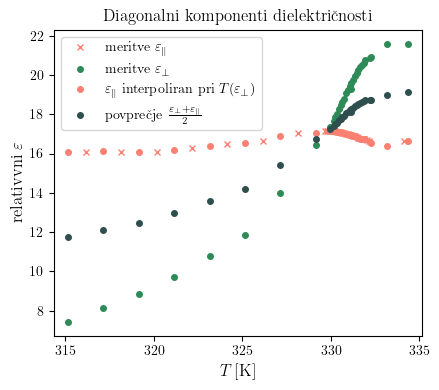

In [5]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=[4.5, 4])

ax.plot(T_1, ε_1, color='salmon',linestyle='', marker='x',
        markersize=4, label=r'meritve $\varepsilon_\parallel$')
ax.plot(T_2, ε_2, color='seagreen',linestyle='', marker='o',
        markersize=4, label=r'meritve $\varepsilon_\perp$')
ax.plot(T_2, ε_1_at_T_2, color='salmon',linestyle='', marker='o',
        markersize=4, label=r'$\varepsilon_\parallel$ interpoliran pri $T(\varepsilon_\perp)$')

ax.plot(T_2, ε_mean, color='darkslategrey',linestyle='', marker='o',
        markersize=4, label=r'povprečje $\frac{\varepsilon_\perp + \varepsilon_\parallel}{2}$')

ax.set_title(f'Diagonalni komponenti dielektričnosti')
ax.set_xlabel(r'$T\,[\mathrm{K}]$')
ax.set_ylabel(r'relativvni $\varepsilon$')
ax.set_xlim(np.min(T_2)-0.8, np.max(T_2)+0.8)
ax.legend()
fig.tight_layout()
fig.savefig(f'eps-by-T.pdf')

(331.0, -0.32500000000000284, 57.85000000000002)

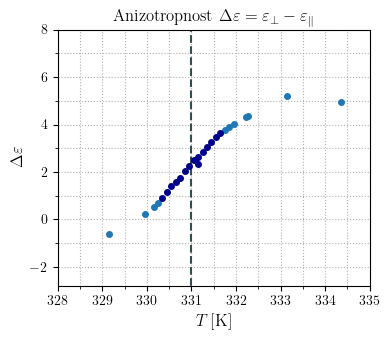

In [128]:
from matplotlib.ticker import AutoMinorLocator

# Region of phase transition (somewhat arbitrary)
indices = (T_2 > 330.3) * (T_2 < 331.7)
T_c = (np.max(T_2[indices]) + np.min(T_2[indices]))/2
ΔT_c = (np.min(T_2[indices]) - np.max(T_2[indices]))/4

# Plot
fig, ax = plt.subplots(1, 1, figsize=[4, 3.5])

ax.plot(T_2[~indices], Δε[~indices], color='tab:blue',linestyle='',
        marker='o', markersize=4, zorder=3)
ax.plot(T_2[indices], Δε[indices], color='darkblue',linestyle='',
        marker='o', markersize=4, zorder=3)
ax.plot([T_c, T_c], [-10, 10], color='darkslategrey',linestyle='--')

ax.set_title(r'Anizotropnost $\Delta\varepsilon = \varepsilon_\perp - \varepsilon_\parallel$')
ax.set_xlabel(r'$T\,[\mathrm{K}]$')
ax.set_ylabel(r'$\Delta\varepsilon$')
ax.set_xlim(328, 335)
ax.set_ylim(-2.8, 8)
ax.grid(which='both', linestyle=':')
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
fig.tight_layout()
fig.savefig(f'anisotropy.pdf')
T_c, ΔT_c, T_c - 273.15

In [57]:
def linear(x, k, c):
    return k*x + c

(1.9500000000000002,
 0.16999999999999998,
 7.197962250387226,
 0.36433527345346967,
 1.4281909312240888,
 0.25929858156996866)

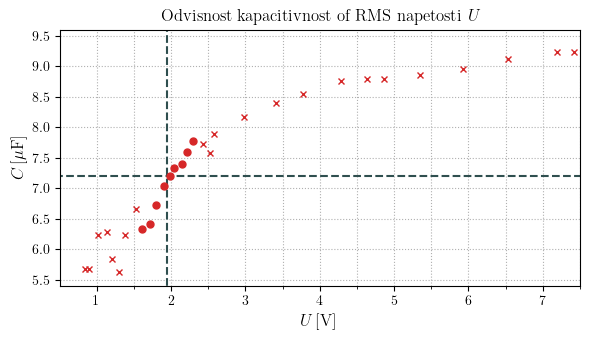

In [147]:
R = 1e3
ν = 10e3
U, RI = meas_dict['frederiks-U-by-I'] # All RMS
U, RI = 1e-3 * U, 1e-3 * RI
I = RI/R
C = I/(2*np.pi*U)

# Region of phase transition (somewhat arbitrary)
indices = (U > 1.6) * (U < 2.3)
U_c  = (np.max(U[indices]) + np.min(U[indices]))/2
ΔU_c = (np.max(U[indices]) - np.min(U[indices]))/4
C_c = C[np.argmin((U - U_c)**2)]
ΔC_c = (np.max(C[indices]) - np.min(C[indices]))/4
S = 2e-2**2
d = 20.6e-6
Δεε_0 = C_c * d/S # High anisotropy, Δε ~= ε_parallel
ΔΔεε_0 = ΔC_c * d/S
K_1 = 1/np.pi**2 * U_c**2 * Δεε_0
ΔK_1 = np.sqrt(
    (1/np.pi**2 * 2*U_c * Δεε_0 * ΔU_c)**2 +
    (1/np.pi**2 * U_c**2 * ΔΔεε_0)**2
)

# Plot
fig, ax = plt.subplots(1, 1, figsize=[6, 3.5])

ax.plot(U[~indices], 1e6 * C[~indices], color='tab:red',linestyle='',
        marker='x', markersize=5, zorder=3)
ax.plot(U[indices], 1e6 * C[indices], color='tab:red',linestyle='',
        marker='o', markersize=5, zorder=3)
ax.plot([U_c, U_c], [0, 10], color='darkslategrey',linestyle='--')
ax.plot([0, 10], [1e6 * C_c]*2, color='darkslategrey',linestyle='--')

ax.set_title(r'Odvisnost kapacitivnost of RMS napetosti $U$')
ax.set_xlabel(r'$U\,[\mathrm{V}]$')
ax.set_ylabel(r'$C\,[\mathrm{\mu F}]$')
ax.set_xlim(0.5, 7.5)
ax.set_ylim(5.4, 9.6)
ax.set_xticks(list(range(1, 8)))
ax.grid(which='both', linestyle=':')
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
fig.tight_layout()
fig.savefig(f'C-by-U.pdf')
U_c, ΔU_c, 1e6 * C_c, 1e6 * ΔC_c, 1e7 * K_1, 1e7 * ΔK_1